# Predictions in Social Networks

**Data Description:**
- The Dataset **nodes_df.csv** contains information about the `Department`(indicating the department in the company which the person belongs to) and the `ManagementSalary` (indicating whether that person is receiving a management position salary) of people in a company 
- The Dataset **edge_list.csv** contains information about the email-communication: each edge indicates that at least one email has been sent between two people
- The Dataset **Future_Connections.csv** contains pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection and value 0.0 indicates no connection. Some connections have no value yet.

**Predictions:**
1. `ManagementSalary`: Some people in the network have missing information about the Management Salary - I will predict whether or not these individuals are receiving a management position salary. For this purpose I will create a matrix of node features using networkx, train a LR classifier on nodes that have ManagementSalary data, and predict the probability of receiving a management salary for nodes where this is missing. 

2. `Future connections`:  I will create a matrix of features for the edges using networkx and train a LR classifier classifier on edges, that have a connection and predict the probability of receiving a connection for those edges with a missing connection. 


In [11]:
#loading the libraries
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc,  confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
#loading the nodes_df dataset
df= pd.read_csv('nodes_df.csv')
df.head()

,Department,ManagementSalary
0,1,0.0
1,1,NaN
2,21,NaN
3,21,1.0
4,21,1.0


In [15]:
#load the edge_list dataset
import csv
with open('edge_list.csv') as csvfile:
    edges = list(csv.reader(csvfile)) # ginbt eine dictionary ansicht der file wieder
edges = [x for x in edges if x]
del edges[0]
edges_tups=[(i[0], i[1]) for i in edges]

In [17]:
#building a graph from the data
G1=nx.Graph()
G1.add_edges_from(edges_tups)

### 1. Predicting Management Salary

In [18]:
df.index= df.index.astype('str')

In [19]:
#creating the matrix
deg= dict(G1.degree())
df['degree_od_node'] = list(deg.values())
df['clustering_coefficiant'] = pd.Series(nx.clustering(G1))
df['degree_centrality'] = pd.Series(nx.degree_centrality(G1))
df['closeness_centrality'] = pd.Series(nx.closeness_centrality(G1))
df['beteen_centrality'] = pd.Series(nx.betweenness_centrality(G1, normalized = True, endpoints= False))
df['page_rank']= pd.Series(nx.pagerank(G1, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None))
df['hubs'] = pd.Series(nx.hits(G1)[0])
df['authorities'] = pd.Series(nx.hits(G1)[1])

In [20]:
df.head()

,Department,ManagementSalary,degree_od_node,clustering_coefficiant,degree_centrality,closeness_centrality,beteen_centrality,page_rank,hubs,authorities
0,1,0.0,44,0.276423,0.043825,0.421991,0.001124,0.001224,0.000944,0.000944
1,1,NaN,52,0.265306,0.051793,0.422360,0.001195,0.001426,0.001472,0.001472
2,21,NaN,111,0.297803,0.094622,0.461490,0.006570,0.002605,0.002680,0.002680
3,21,1.0,47,0.384910,0.070717,0.441663,0.001654,0.001833,0.002369,0.002369
4,21,1.0,30,0.318691,0.095618,0.462152,0.005547,0.002526,0.003055,0.003055


In [21]:
#standardizing the continous variables
cols = list(df.columns)
del cols[0]
del cols[0]
for i in cols:
    df[[i]] = StandardScaler().fit_transform(df[[i]])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
#creating subsets for prediction
trainset= df.dropna(subset=['ManagementSalary'], axis= 0) 
X= trainset.drop("ManagementSalary", 1) #nur eine
y= trainset["ManagementSalary"]
miss = df[df['ManagementSalary'].isnull()]
miss_X= miss.drop("ManagementSalary", 1)

In [23]:
#getting dummies for the categorical variable "Department" - for X and miss_X
dum = pd.get_dummies(X["Department"], prefix="Department")
X = pd.concat([X, dum], axis=1)
X.drop(["Department"], axis = 1, inplace=True)
dum = pd.get_dummies(miss_X["Department"], prefix="Department")
miss_X = pd.concat([miss_X, dum], axis=1)
miss_X.drop(["Department"], axis = 1, inplace=True)

In [24]:
X.head()

,degree_od_node,clustering_coefficiant,degree_centrality,closeness_centrality,beteen_centrality,page_rank,hubs,authorities,Department_0,Department_1,...,Department_32,Department_33,Department_34,Department_35,Department_36,Department_37,Department_38,Department_39,Department_40,Department_41
0,0.288218,-0.488668,0.288218,0.565407,-0.090596,0.249207,-0.040889,-0.040889,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.368619,-0.057418,1.011828,0.828308,0.029657,0.911739,1.105256,1.105256,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.086988,-0.320646,1.681838,1.102114,0.913396,1.665788,1.657267,1.657267,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.100615,-0.970608,2.191046,1.284571,2.465577,2.339609,1.254697,1.254697,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.743824,-0.443504,1.038629,0.540888,0.293856,1.095434,0.128712,0.128712,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
miss_X.head()

,degree_od_node,clustering_coefficiant,degree_centrality,closeness_centrality,beteen_centrality,page_rank,hubs,authorities,Department_0,Department_1,...,Department_31,Department_32,Department_34,Department_35,Department_36,Department_37,Department_38,Department_39,Department_40,Department_41
1,0.502621,-0.532858,0.502621,0.570337,-0.074398,0.468737,0.383696,0.383696,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2.083844,-0.403681,1.655038,1.093266,1.145400,1.750844,1.355688,1.355688,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.033387,-1.162134,3.691868,1.627746,6.688760,4.263020,2.426389,2.426389,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.931427,0.189628,0.100615,0.447265,-0.219254,0.069913,-0.163956,-0.163956,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1.574637,-0.729713,1.253032,0.833708,0.499982,1.274013,0.692614,0.692614,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#creating test and train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [27]:
#finding most important features using RFECV
from sklearn.feature_selection import RFECV
LR = LogisticRegression(solver = 'lbfgs')
selector = RFECV(LR, step=1, cv=5)
sel = selector.fit(X_train, y_train)
sel.support_ 

array([False,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [28]:
#creating new X with the selected columns
cols= [i for i, x in enumerate(sel.support_) if x]
X_neu = X.iloc[:, cols]
X_neu.head()

,clustering_coefficiant,closeness_centrality,beteen_centrality,Department_10
0,-0.488668,0.565407,-0.090596,0
3,-0.057418,0.828308,0.029657,0
4,-0.320646,1.102114,0.913396,0
6,-0.970608,1.284571,2.465577,0
7,-0.443504,0.540888,0.293856,0


In [29]:
#creating new test and train sets
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split( X_neu, y, test_size=0.2, random_state=4)

In [31]:
#suing grid search to search for a good C Parameter
grid_values = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
LR = LogisticRegression(solver ='liblinear')
grid= GridSearchCV(LR, param_grid = grid_values, scoring= 'roc_auc', cv=5)
grid.fit(X_train_n, y_train_n)
decisionf = grid.decision_function(X_test_n)
c = grid.best_params_["C"]

In [32]:
LR = LogisticRegression(C=c, solver ='liblinear')
LR.fit(X_train_n, y_train_n)
yhat = LR.predict(X_test_n)
y_score = LR.decision_function(X_test_n)
auc = roc_auc_score(y_test_n, y_score)
auc

0.9532520325203252

In [33]:
#plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 17  11]
 [  3 120]]


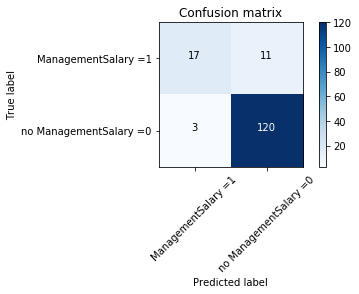

In [34]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['ManagementSalary =1','no ManagementSalary =0'],normalize= False,  title='Confusion matrix') 

In [35]:
#preparing miss_X for new predictions
coltr = X_train_n.columns.tolist()
colte = miss_X.columns.tolist()
col_only_train = []
for i in coltr:
    if i not in colte:
        col_only_train.append(i)
col_only_test= []

for i in colte:
    if i not in coltr:
        col_only_test.append(i)

#Adding for the missing columns in test set default value 0
for c in col_only_train:
    miss_X[c] = 0

# putting order of columns in same order in both sets
miss_X.drop([i for i in col_only_test],axis = 1, inplace = True)

#dropping columns that are only in the test set
miss_X = miss_X[X_train_n.columns]    

In [36]:
miss_X.shape

(252, 4)

In [37]:
# calculating the probability of receiving a management salary
y_miss_prob = LR.predict_proba(miss_X)
liste= [i[1] for i in y_miss_prob]
s = pd.Series(liste, index = [miss.index])
s[:5]

1     0.035247
2     0.802834
5     0.999997
8     0.079227
14    0.167909
dtype: float64

### 2.  Predicting New Connections 


In [41]:
#creating dataframe with edges as indexes
df_edge= pd.DataFrame(index=edges_tups)
#for predictions also adding the information from the existng nodes = marking Future-connection as 1
df_edge['Future Connection'] = 1
df_edge.head()

,Future Connection
"(0, 1)",1
"(0, 17)",1
"(0, 316)",1
"(0, 146)",1
"(0, 581)",1


In [43]:
#loading dataset with future connections
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head()

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0


In [44]:
#combining the two datasets
trainset_e= future_connections.append(df_edge)

In [45]:
#converting the index to tuples of strings 
new_tups = []
for tup in trainset_e.index:
    x= [str(i) for i in tup]
    x= tuple(x)
    new_tups.append(x)
trainset_e.index = new_tups

In [46]:
#creating features for the edges
trainset_e['preferential attachment'] = [i[2] for i in nx.preferential_attachment(G1,trainset_e.index.values)]
trainset_e['Common Neighbors'] = trainset_e.index.map(lambda x: len(list(nx.common_neighbors(G1, x[0], x[1]))))

In [47]:
trainset_e['ressource_allocation'] = [i[2] for i in nx.resource_allocation_index(G1, trainset_e.index)]

In [48]:
trainset_e['jaccard'] = [i[2] for i in nx.jaccard_coefficient(G1, trainset_e.index)]

In [49]:
aa=[]
for i in trainset_e.index:
    try:
        x = list(nx.adamic_adar_index(G1, [i]))
        aa.append(x[0][2])
    except:
        aa.append(0)
trainset_e['adamic adar'] = aa

In [50]:
trainset_e.head()

,Future Connection,preferential attachment,Common Neighbors,ressource_allocation,jaccard,adamic adar
"(6, 840)",0.0,2070,9,0.136721,0.073770,2.110314
"(4, 197)",0.0,3552,2,0.008437,0.015504,0.363528
"(620, 979)",0.0,28,0,0.000000,0.000000,0.000000
"(519, 872)",0.0,299,2,0.039726,0.060606,0.507553
"(382, 423)",0.0,205,0,0.000000,0.000000,0.000000


In [51]:
#creating subsets for prediction
miss = trainset_e[trainset_e['Future Connection'].isnull()]
miss_X= miss.drop('Future Connection', 1)

In [52]:
trainset_e.dropna(subset=['Future Connection'], axis=0, inplace = True)
X = trainset_e.drop('Future Connection', 1)
y= trainset_e['Future Connection']

In [53]:
#standardize variables
for i in X.columns:
    X[[i]] = StandardScaler().fit_transform(X[[i]])
for i in miss_X.columns:
     miss_X[[i]] = StandardScaler().fit_transform(miss_X[[i]])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by

In [54]:
#creating test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [55]:
#finding most important features using RFECV
from sklearn.feature_selection import RFECV
LR = LogisticRegression(solver = 'lbfgs')
selector = RFECV(LR, step=1, cv=5)
sel = selector.fit(X_train, y_train)
sel.support_ 

array([ True,  True,  True,  True,  True])

In [29]:
#getting numbers of selected columns
cols= [i for i, x in enumerate(sel.support_) if x]
X_neu = X.iloc[:, cols]
X_neu.head()

,Common Neighbors,ressource_allocation,jaccard
"(6, 840)",0.960729,0.842122,0.728000
"(4, 197)",-0.088703,-0.217936,-0.187887
"(620, 979)",-0.388541,-0.287658,-0.431591
"(519, 872)",-0.088703,0.040609,0.521070
"(382, 423)",-0.388541,-0.287658,-0.431591


In [31]:
#creating new test and train sets
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split( X_neu, y, test_size=0.2, random_state=4)

In [32]:
#using grid search for optimizing parameter C
grid_values = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
LR = LogisticRegression(solver ='liblinear')
grid= GridSearchCV(LR, param_grid = grid_values, scoring= 'roc_auc')
grid.fit(X_train, y_train)
decisionf = grid.decision_function(X_test)
c = grid.best_params_["C"]

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [33]:
#training the classifier
LR = LogisticRegression(C=c, solver ='liblinear')
LR.fit(X_train, y_train)
yhat = LR.predict(X_test)
y_score = LR.decision_function(X_test)
auc = roc_auc_score(y_test, y_score)
auc

0.9296195977868384

Confusion matrix, without normalization
[[ 6186  2924]
 [  738 66760]]


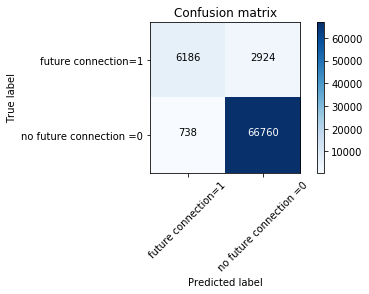

In [36]:
#plotting the confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['future connection=1','no future connection =0'],normalize= False,  title='Confusion matrix') 

In [38]:
#predicting the probability for a connection in the future
y_miss_prob = LR.predict_proba(miss_X)
liste= [i[1] for i in y_miss_prob]
proba_conn = pd.Series(liste, index = [miss.index])
proba_conn[:5]

(107, 348)    0.066084
(542, 751)    0.016101
(20, 426)     0.962855
(50, 989)     0.016048
(942, 986)    0.015992
dtype: float64